# BCDI Reconstruction Analysis

This notebook provides a step-by-step workflow for analysing and comparing Bragg Coherent Diffraction Imaging (BCDI) reconstructions stored in CXI files. You'll learn how to:

1. Explore CXI file structure with `CXIExplorer`
2. Load specific datasets from reconstructions
3. Visualise and compare different conditions and quantities
4. Generate customised plots for analysis

Of course, this is just a starting point. You can adapt the code to suit your specific needs and datasets. Copy the code snippets into your own Jupyter notebook and modify them as needed.

## 1. Setup and Initialisation

In [1]:
# Import required packages
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

import cdiutils


# Set default plotting parameters
cdiutils.plot.update_plot_params()

### 1.1 Set Paths to Your Data

First, specify the directory where your reconstruction results are stored.

In [2]:
results_dir = (
    "path/to/the/results/directory"  # Replace with the actual path to your results directory
)

### 1.2 Explore CXI File Structure

The `CXIExplorer` lets you interactively explore the structure of your CXI files before loading specific data. This helps you identify available datasets and their paths. Here, we only use the `CXIExplorer.explore()` method, but an you can find more about how to explore CXI file in the `explore_cxi_file.ipynb` notebook.

Select one of your CXI files to explore:

In [3]:
# Path to one of your CXI files for exploration
cxi_path = results_dir + "Sample_Name/S000/S000_postprocessed_data.cxi"

cxi_path = "/scisoft/clatlan/dev/tutorials/examples_and_tutorials/analysis/results/B18S2P1_Ni/S706/S706_postprocessed_data.cxi"

# Initialise a new explorer instance
explorer = cdiutils.io.CXIExplorer(cxi_path)

# Launch the interactive browser
explorer.explore()


In [4]:
# Make sure to close the explorer when done
explorer.close()

### 1.3 Define Samples and Conditions

Create a table matching experimental conditions to sample names and scan numbers. This will help organise your data for comparison.

In [ ]:
# Create a table of conditions and corresponding samples
# Format: (condition_name, sample_name, scan_number)
table = [
    # Example entries - replace with your actual data
    ("Condition_A", "Sample_Name_A", 3),
    ("Condition_B", "Sample_Name_B", 6),
    ("Condition_C", "Sample_Name_C", 6),
    ("Condition_D", "Sample_Name_D", 3),
    # Add more conditions as needed
]

### 1.4 Load Data from CXI Files

Now we'll load specific datasets from each sample's CXI file. Based on the file exploration above, you can identify which quantities to load.

`cdiutils` provides a convenient function to load data from CXI files. You can use the `cdiutils.io.load_cxi` function to conveniently load data from CXI files. The `cdiutils` library provides a convenient function to load data from CXI files. It requires the path to the CXI file and a dataset name to load. If the dataset name is not the exact full "key path", say `"voxel_size"` instead of `"entry_1/result_1/voxel_size"`, the function will find it for you anyway. Note that you can provide as much as keys as you want, and the function will return a dictionary with the keys as the dataset names and the values as the data loaded from the CXI file.

In [6]:
# List of quantities to extract from CXI files
quantities = (
    "support", "het_strain", "het_strain_from_dspacing", "dspacing",
    "amplitude", "displacement", "phase", "lattice_parameter"
    # Add or remove quantities based on your needs
)

# initialise the voxel_sizes dictionary
voxel_sizes = {condition: None for condition, _, _ in table}
# Path to the results directory

# Initialize a dictionary to store the structural properties
structural_properties = {
    condition: {} for condition, _, _ in table
}

# Path template for post-processed data
path_template = results_dir + "{}/S{}/S{}_postprocessed_data.cxi"

# Load data for each condition
for condition, sample_name, scan in table:
    path = path_template.format(sample_name, scan, scan)
    
    # Load all specified quantities from the CXI file
    structural_properties[condition] = cdiutils.io.load_cxi(path, *quantities)
    voxel_sizes[condition] =  cdiutils.io.load_cxi(path, "voxel_size")

# Apply support mask: set values outside the support to NaN
for key in quantities:
    if key != "support" and key != "amplitude":  # Keep amplitude outside support
        for condition, _, _ in table:
            structural_properties[condition][key] *= cdiutils.utils.zero_to_nan(
                structural_properties[condition]["support"]
            )

## 2. Visualise and Compare Datasets

### 2.1 Configure Plot Settings

Set up color maps and value ranges for visualising different quantities. The `cdiutils` package provides default configurations that you can customize.

In [7]:
# Get the default plot configurations from cdiutils
_, _, plot_configs = cdiutils.plot.set_plot_configs()

To check out the predefined colour maps, you can copy/paste this code in 
a cell and run it:
```python
print("Plot configs:")
print("=============\n")
for quantity, d in plot_configs.items():
    print(f'"{quantity}": ')
    for key, value in d.items():
        print(f'\t"{key}": {value}')
```

### 2.2 Visualise Individual Quantities

Let's start by plotting a single quantity (e.g., heterogeneous strain) for all conditions to compare them.

- **With `cdiutils.plot.plot_volume_slices`**: This function allows you to plot slices of a single 3D data volume. You can specify the quantity, colormap, and value range for visualisation.

>_**Notes:**_
>
>_If no `convention` is provided, we use "natural" plotting conventions, i.e.:_
> - _first slice plot: slice taken at the middle of dim0, dim1 along y-axis, dim2 along x-axis_
> - _second slice plot: slice taken at the middle of dim1, dim0 along y-axis, dim2 along x-axis_
> - _third slice plot: slice taken at the middle of dim2, dim0 along y-axis, dim1 along x-axis_

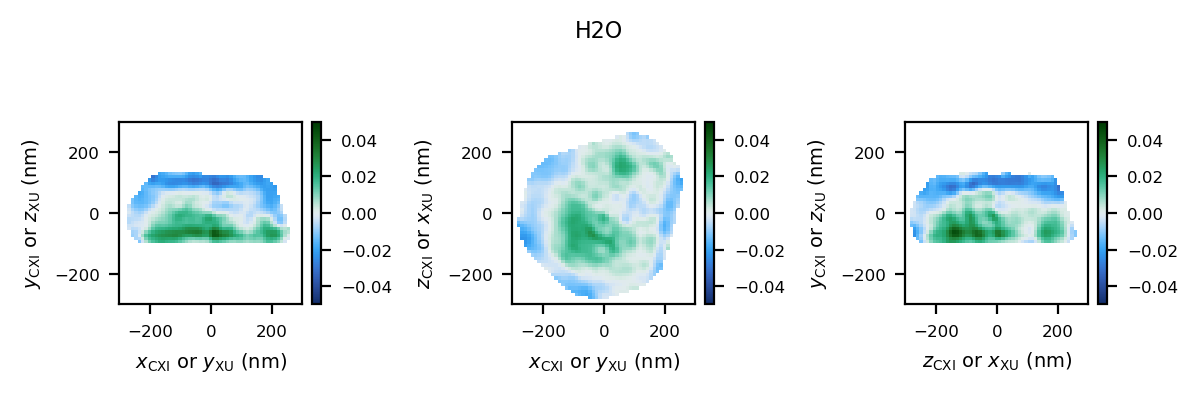

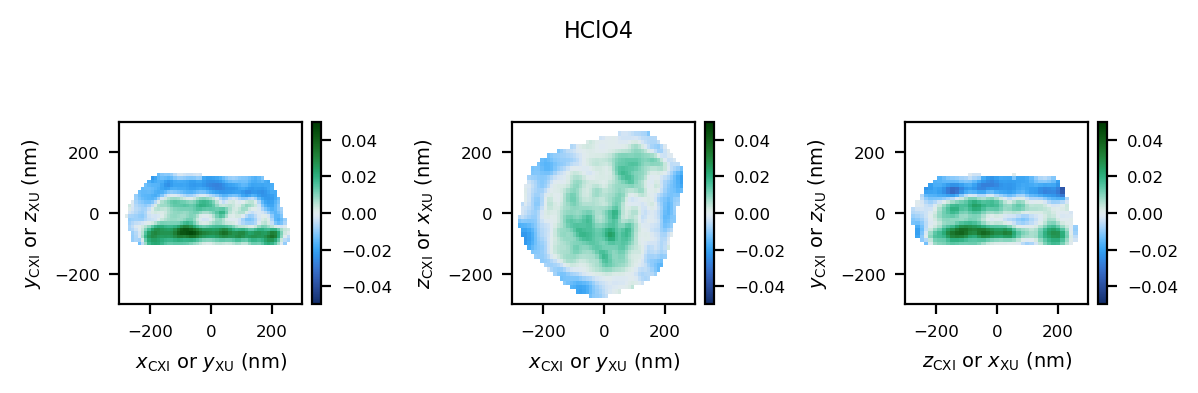

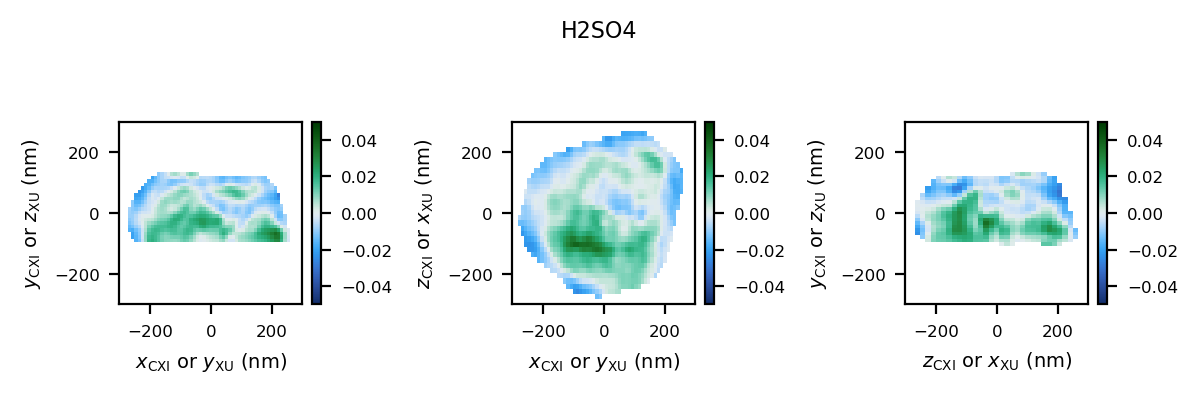

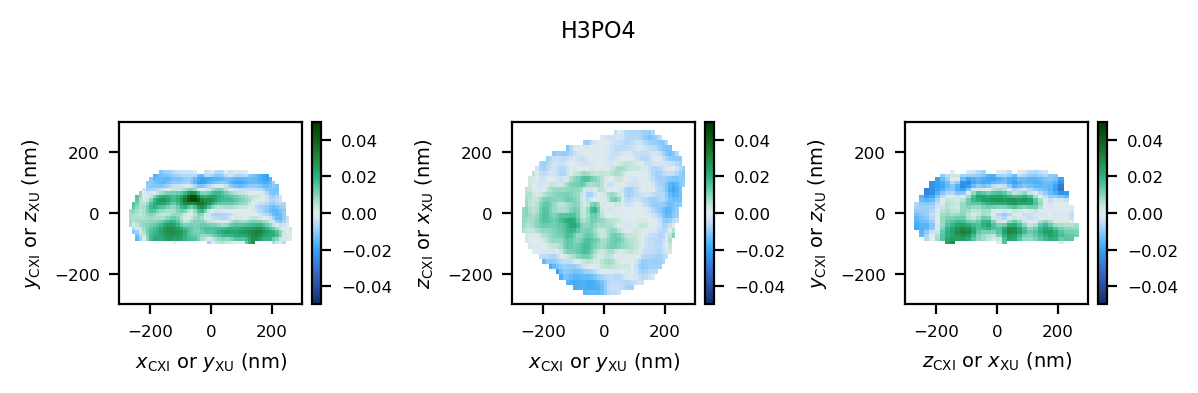

In [8]:
# Select the quantity to visualise
quantity = "het_strain"  # Change this to any quantity from your list

# Plot the selected quantity for each condition
for (condition, _, _) in table:
    fig, axes = cdiutils.plot.plot_volume_slices(
        structural_properties[condition][quantity],
        title=condition,
        cmap=plot_configs[quantity]["cmap"],
        
        # comment this block if you don't need real size extents
        voxel_size=voxel_sizes[condition],
        data_centre=(0, 0, 0),
        show=False,
        convention="cxi",
        
        # Adjust these colouring limits based on your data
        vmin=-0.05,
        vmax=0.05,
    )
    
    # comment this block if you don't need real size extents
    for ax in axes.flat:
        ax.set_xlim(-300, 300)  # nm
        ax.set_ylim(-300, 300)  #nm
    
    # comment this block if you don't need real size extents
    cdiutils.plot.add_labels(axes)
    display(fig)

### 2.3 Comparing Multiple Volumes Simultaneously

The `plot_multiple_volume_slices` function allows you to visualize and compare multiple 3D volumes in a single figure. It's particularly useful for comparing the same quantity across different experimental conditions or different quantities for the same sample.

#### **Basic Usage**

At its simplest, you can just pass multiple datasets:

```python
cdiutils.plot.plot_multiple_volume_slices(
    *[structural_properties[c][quantity] for c, _, _ in table]
)
```
#### **Customisation Options**
The function accepts all parameters from plot_volume_slices plus additional layout options:

- **Different Layouts**: Choose between vertical (`"v"`) or horizontal (`"h"`) stacking with `data_stacking`
- **Real-Space Plotting**: Use `voxel_sizes` and `data_centres` for physical units
- **Consistent Views:**: Apply the same convention to all datasets with `convention="cxi"` or `"xu"`
- **Custom Limits**: Set uniform axis limits with `xlim` and `ylim`
- **Colorbar Control**: Configure the `colorbar` appearance with `cbar_args`

#### **Advanced Example**
Here's how to create a publication-ready comparison plot:

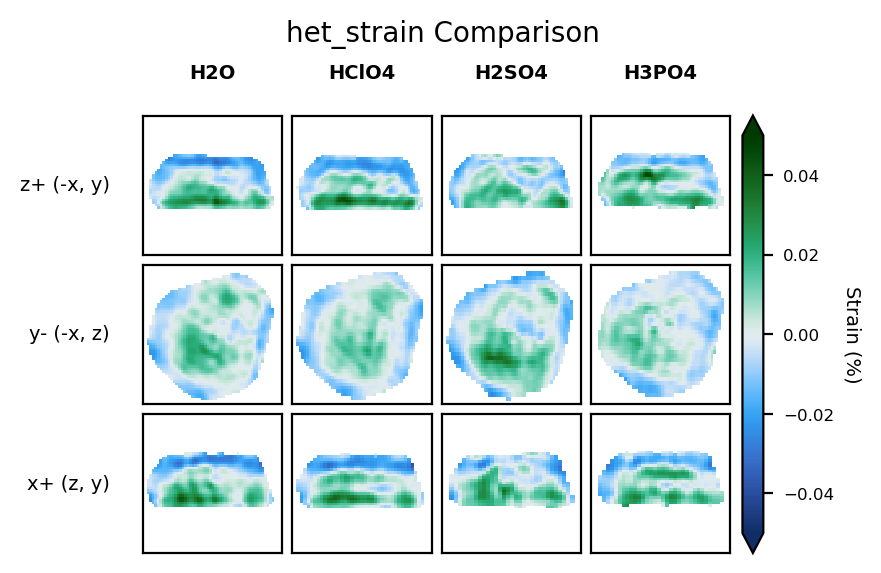

In [ ]:
fig = cdiutils.plot.plot_multiple_volume_slices(
    *[structural_properties[c][quantity] for c, _, _ in table],
    voxel_sizes=[voxel_sizes[c] for c, _, _ in table],  # For physical units
    data_labels=[c for c, _, _ in table],               # Label each dataset
    data_centres=[(0, 0, 0) for _ in table],            # Center of each dataset
    convention="cxi",                                   # Use CXI convention for views 
    # data_stacking="v",                                # Stack datasets vertically
    # pvs_args={"views": ["z+", "y+", "x+"]},           # Specific view directions
    cbar_args={"location": "right",                     # Colorbar on the right
               "title": plot_configs[quantity]["title"]}, # Title from configs
    xlim=(-300, 300),                                   # Consistent x limits in the same units as voxel size
    ylim=(-300, 300),                                   # Consistent y limits in the same units as voxel size
    cmap=plot_configs[quantity]["cmap"],                # Apply a custom colormap
    vmin=-0.05,                                         # Set min value for colormap
    vmax=0.05,                                          # Set max value for colormap
    remove_ticks=True,                                  # Clean appearance without ticks
    title=f"{quantity} Comparison"                      # Title above the figure
)

### 2.3 Compare Multiple Quantities Across Conditions

To get a comprehensive view, we can plot all quantities for each condition. This helps identify correlations between different physical properties.

We need to set the minimum and maximum values for each quantity to ensure consistent visualisation across all conditions.

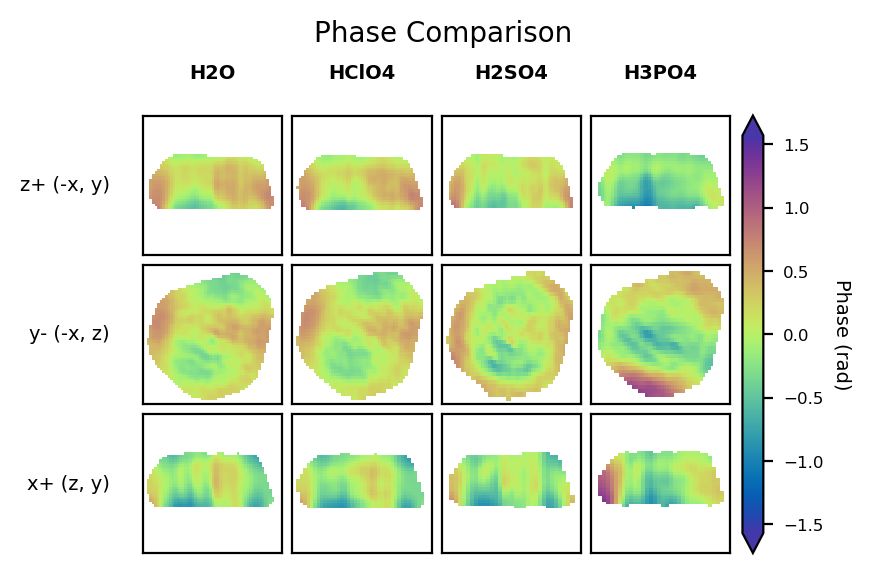

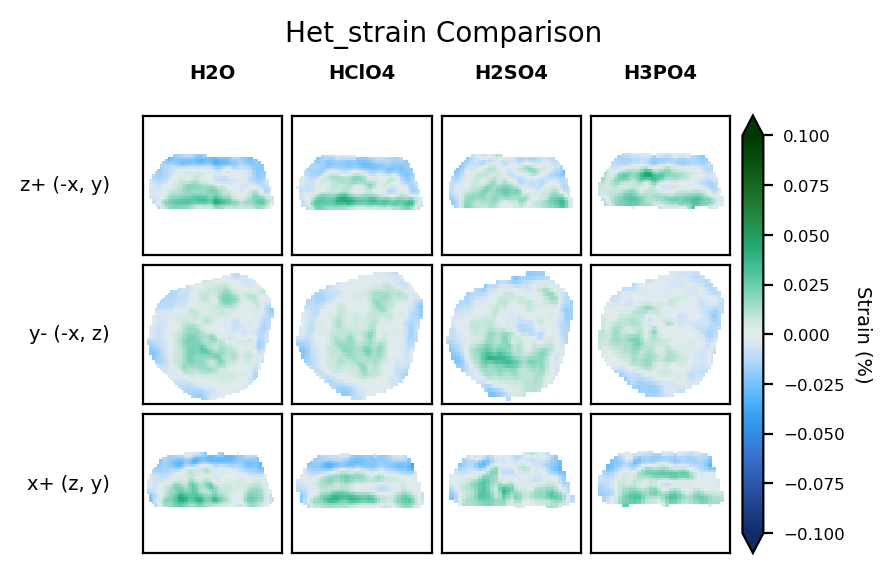

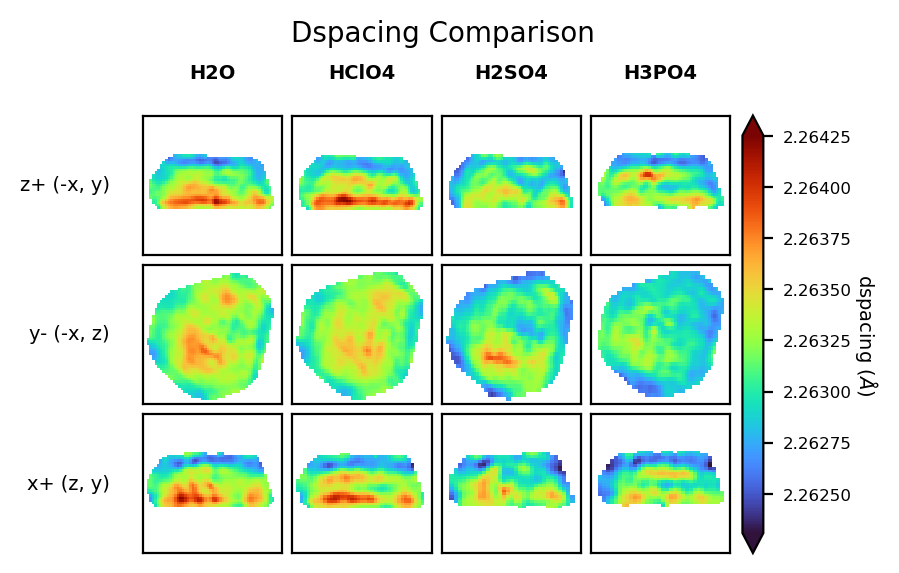

In [ ]:
# Define min and max values for each quantity
# Adjust these values based on your data ranges
vmins = {
    "support": 0,
    "het_strain": -0.1,
    "het_strain_from_dspacing": -0.1,
    "dspacing": None,  # Set to None for automatic range
    "amplitude": None,
    "displacement": -0.2,
    "phase": -np.pi/2,
}
vmaxs = {
    "support": 1,
    "het_strain": 0.1,
    "het_strain_from_dspacing": 0.1,
    "dspacing": None,
    "amplitude": None,
    "displacement": 0.2,
    "phase": np.pi/2,
}
for key in plot_configs.keys():
    if key not in vmins:
        vmins[key] = plot_configs[key]["vmin"]
    if key not in vmaxs:
        vmaxs[key] = plot_configs[key]["vmax"]

# To visualise only a subset of quantities, uncomment and modify this list
custom_quantities = ["phase", "het_strain", "dspacing"]
# Then use custom_quantities instead of quantities in the loop below

# For each quantity, plot all conditions
for quantity in custom_quantities:  # Change to custom_quantities if defined above
    fig = cdiutils.plot.plot_multiple_volume_slices(
        *[structural_properties[c][quantity] for c, _, _ in table],
        voxel_sizes=[voxel_sizes[c] for c, _, _ in table],
        data_labels=[c for c, _, _ in table],
        data_centres=[(0, 0, 0) for _ in table],
        convention="cxi", 
        cbar_args={"title": plot_configs[quantity]["title"]},
        xlim=(-300, 300),     
        ylim=(-300, 300),
        cmap=plot_configs[quantity]["cmap"],
        vmin=vmins[quantity],
        vmax=vmaxs[quantity],
        remove_ticks=True,
        title=f"{quantity.capitalize()} Comparison"
    )

## 3. Comparing Reciprocal Space Data

Besides real-space reconstructions, it's often valuable to compare the original diffraction data in the (orthogonalised) reciprocal space.

### 3.1 Load the Reciprocal Space Data
This time, we will load the reciprocal space data from the `.../S...preprocessed_data.cxi`-type CXI files.

In [12]:
# Initialise a dictionary for reciprocal space data
reciprocal_space_data = {condition: {} for condition, _, _ in table}

# Path template for preprocessed data
path_template = results_dir + "{}/S{}/S{}_preprocessed_data.cxi"

# Load reciprocal space data for each condition
for condition, sample_name, scan in table:
    path = path_template.format(sample_name, scan, scan)
    
    # Load orthogonalized detector data
    reciprocal_space_data[condition]["ortho_data"] = cdiutils.io.load_cxi(
        path, "orthogonalised_detector_data"
    )
    
    # Get q-space information
    reciprocal_space_data[condition]["q_spacing"] = []
    for ax in ("qx_xu", "qy_xu", "qz_xu"):
        reciprocal_space_data[condition]["q_spacing"].append(
            np.mean(
                np.diff(cdiutils.io.load_cxi(path, f"entry_1/result_2/{ax}"))
            )                   
        )
    
    # Get q-space center
    reciprocal_space_data[condition]["q_centre"] = cdiutils.io.load_cxi(
        path, "entry_1/result_2/q_lab_shift"
    )

### 3.2 Visualise the Reciprocal Space Data
We can use the same plotting functions as before to visualise the reciprocal space data. This allows us to compare the diffraction patterns across different conditions.

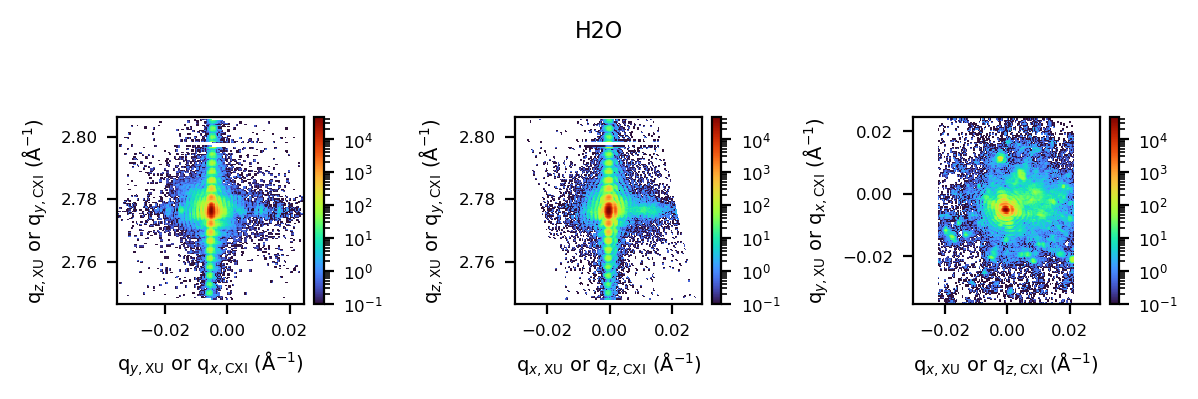

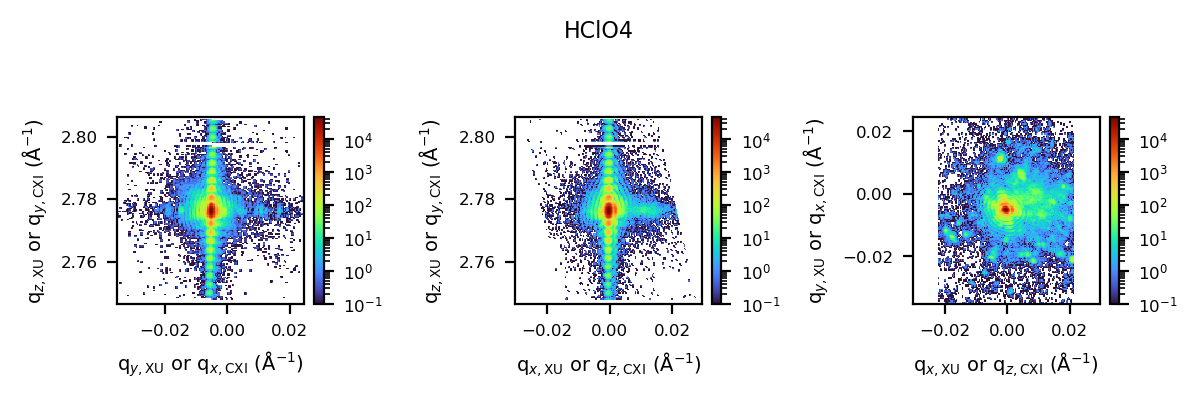

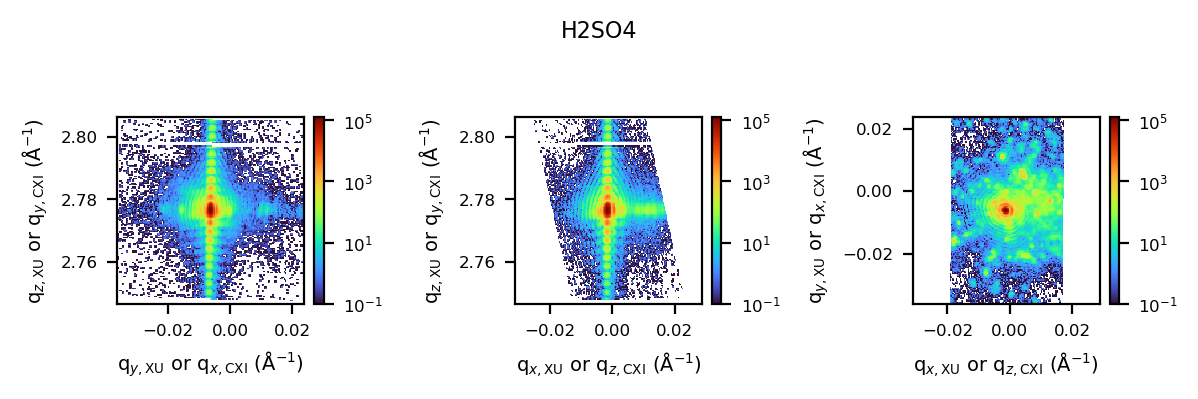

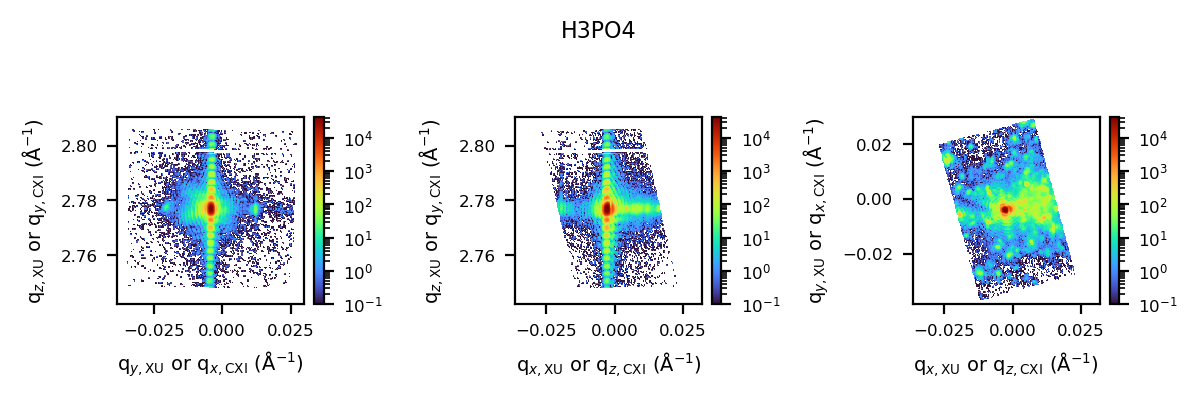

In [130]:
# Plot reciprocal space data for each condition
for (condition, _, _) in table:
    fig, axes = cdiutils.plot.plot_volume_slices(
        reciprocal_space_data[condition]["ortho_data"],
        voxel_size=reciprocal_space_data[condition]["q_spacing"],
        data_centre=reciprocal_space_data[condition]["q_centre"],
        title=condition,
        cmap="turbo",
        norm=LogNorm(1e-1),  # Log scale for diffraction patterns
        convention="xu",
        show=False
    )
    # Add appropriate labels for reciprocal space
    cdiutils.plot.add_labels(axes, space="rcp", convention="xu")
    display(fig)

## 4. Advanced Analysis (customisable)

Here you can add custom analysis specific to your research questions. Some ideas:

- Calculate average strain or d-spacing values for different regions
- Compare phase distributions across conditions
- Extract line profiles through specific features
- Perform statistical analysis on strain or displacement fields

### 4.1 Example (calculate average lattice parameter in the particle):

Average lattice parameter in H2O: 3.92001 Angstrom
Average lattice parameter in HClO4: 3.92002 Angstrom
Average lattice parameter in H2SO4: 3.91970 Angstrom
Average lattice parameter in H3PO4: 3.91965 Angstrom


Text(0.5, 1.0, 'Comparison of Average Lattice Parameter Across Conditions')

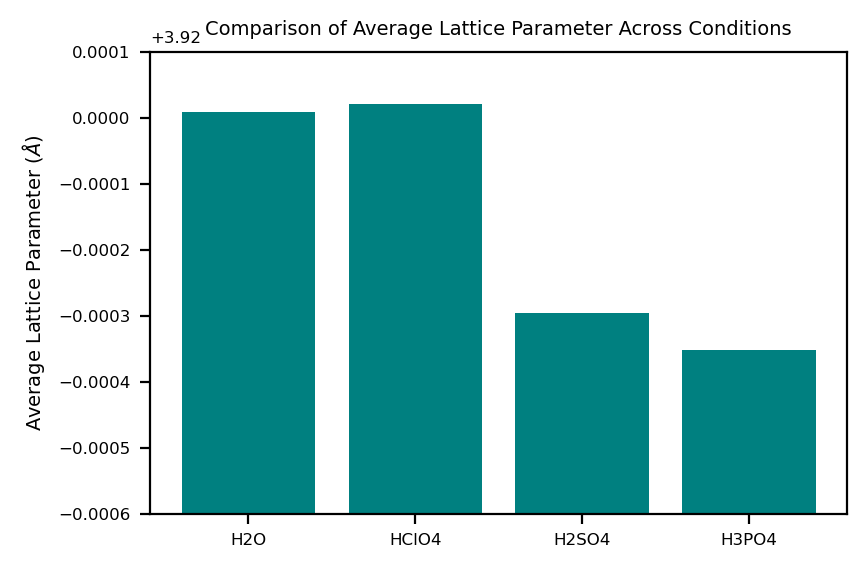

In [13]:
# Example: Calculate average lattice parameter for each condition
avg_lat_par = {}
for condition, _, _ in table:
    lat_par_data = structural_properties[condition]["lattice_parameter"] 
    support = structural_properties[condition]["support"]
    
    # Calculate average within support
    avg_lat_par[condition] = np.nanmean(lat_par_data[support > 0])
    print(
        "Average lattice parameter in "
        f"{condition}: {avg_lat_par[condition]:.5f} Angstrom"
    )

# Plot as a bar chart
plt.figure()
plt.bar(avg_lat_par.keys(), avg_lat_par.values(), color="teal")
plt.ylim(3.9194, 3.9201)
plt.ylabel(r"Average Lattice Parameter ($\AA$)")
plt.title("Comparison of Average Lattice Parameter Across Conditions")

### 4.2 Example (customised histogram plots):

Here we plot the `het_strain_from_dspacing` histogram for all conditions. You can modify the number of bins and the range of values to suit your needs. Note that if you plot other quantities, you may need to adjust the `xlim` and `ylim` values accordingly.


Average het_strain_from_dspacing in H2O: -0.00000 +/- 0.01561
Average het_strain_from_dspacing in HClO4: -0.00000 +/- 0.01606
Average het_strain_from_dspacing in H2SO4: 0.00000 +/- 0.01349
Average het_strain_from_dspacing in H3PO4: 0.00000 +/- 0.01397


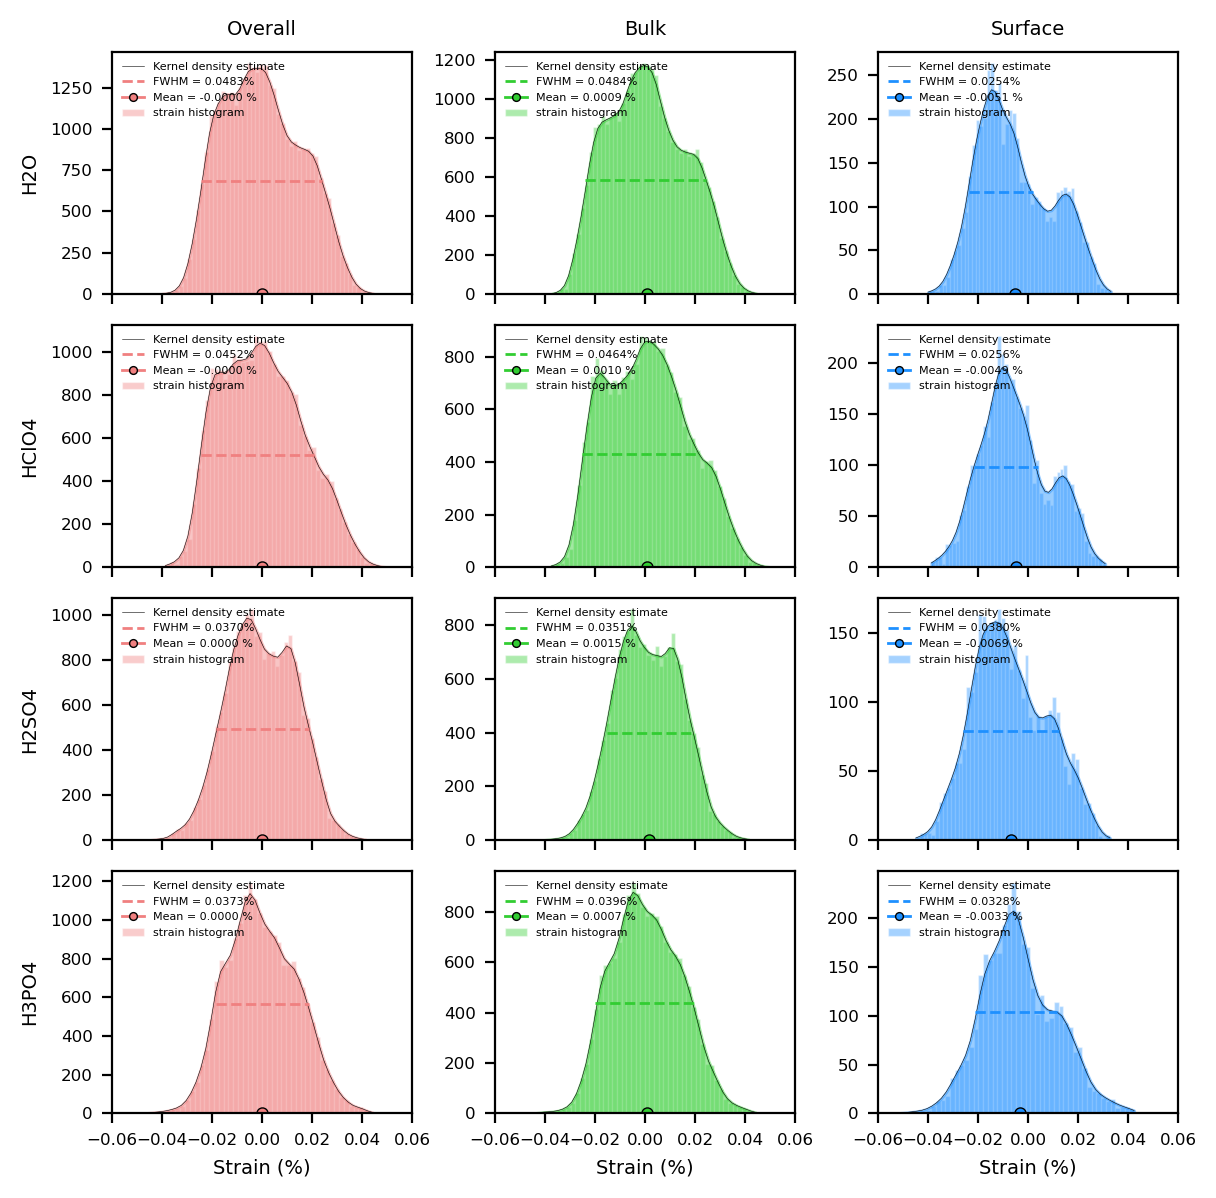

In [14]:
quantity = "het_strain_from_dspacing" 

colors = {
    "overall": "lightcoral",
    "bulk": "limegreen",
    "surface": "dodgerblue"
}


fig, axes = plt.subplots(
    len(table), 3, layout="tight", sharex=True,
    figsize=(6, 1.5*len(table))
)

for i, (condition, _, _) in enumerate(table):
    histograms, kdes, means, stds = cdiutils.analysis.get_histogram(
        structural_properties[condition][quantity],
        structural_properties[condition]["support"],
        bins=50,
        density=False,  # If False you get counts, if True you get density
        region="all"
    )
    # Plot histograms and KDEs
    for j, region in enumerate(histograms.keys()):
        fwhm_value = cdiutils.analysis.plot_histogram(
            axes[i, j],
            *histograms[region],
            *kdes[region],
            color=colors[region],
            fwhm=True,  # Set to True for FWHM plot,
            
            # comment/uncomment lines below to play with the plot options
            bar_args={"edgecolor": "w", "label": "strain histogram"},
            kde_args={"fill": True, "fill_alpha": 0.45, "color": "k", "lw": 0.2},
        )
        
        # Plot the mean
        axes[i, j].plot(
            means[region], 0, color=colors[region], ms=4,
            markeredgecolor="k", marker="o", mew=0.5,
            label=f"Mean = {means[region]:.4f} %"
        )

        axes[i, j].legend(
            fontsize=4, markerscale=0.7, frameon=False, loc="upper left"
        )
        axes[i, j].set_xlim(-0.06, 0.06)  # change this according to your data
        axes[0, j].set_title(f"{region.capitalize()}")
        axes[len(table)-1, j].set_xlabel("Strain (%)")
    axes[i, 0].set_ylabel(condition)
    
    print(
        f"Average {quantity} in {condition}: "
        f"{means['overall']:.5f} +/- {stds['overall']:.5f}"
    )

# Uncomment the line below to save the figure
# cdiutils.plot.save_fig(
#     "output.svg"  # 'svg' if you want to edit with inkscape, 'pdf', 'png'...
#     dpi=300,
# )
    

### 4.3 Example using plotter function used in the pipeline

Strain histograms are plotted for the bulk and the surface of each reconstruction.

>_Note:_
>
> _You can find all functions used for plotting in the `BcdiPipeline` workflow in the `cdiutils.pipeline.PipelinePlotter` class_

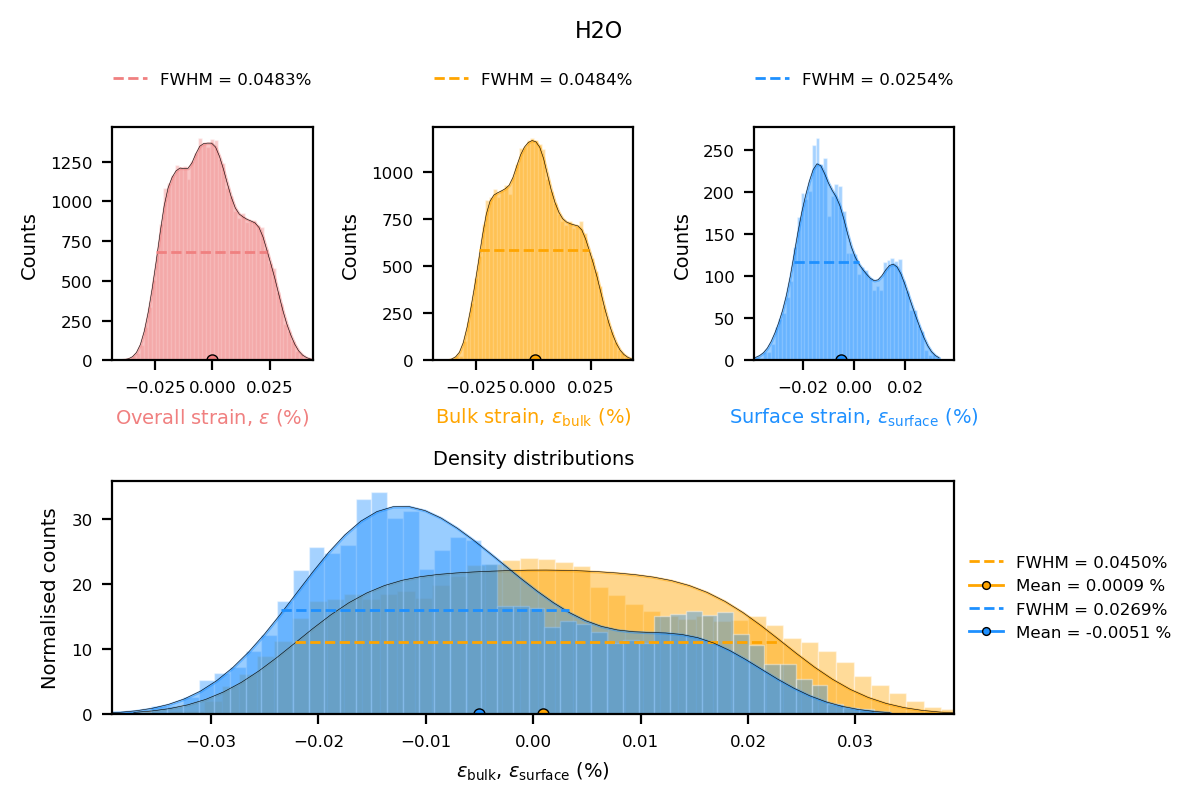

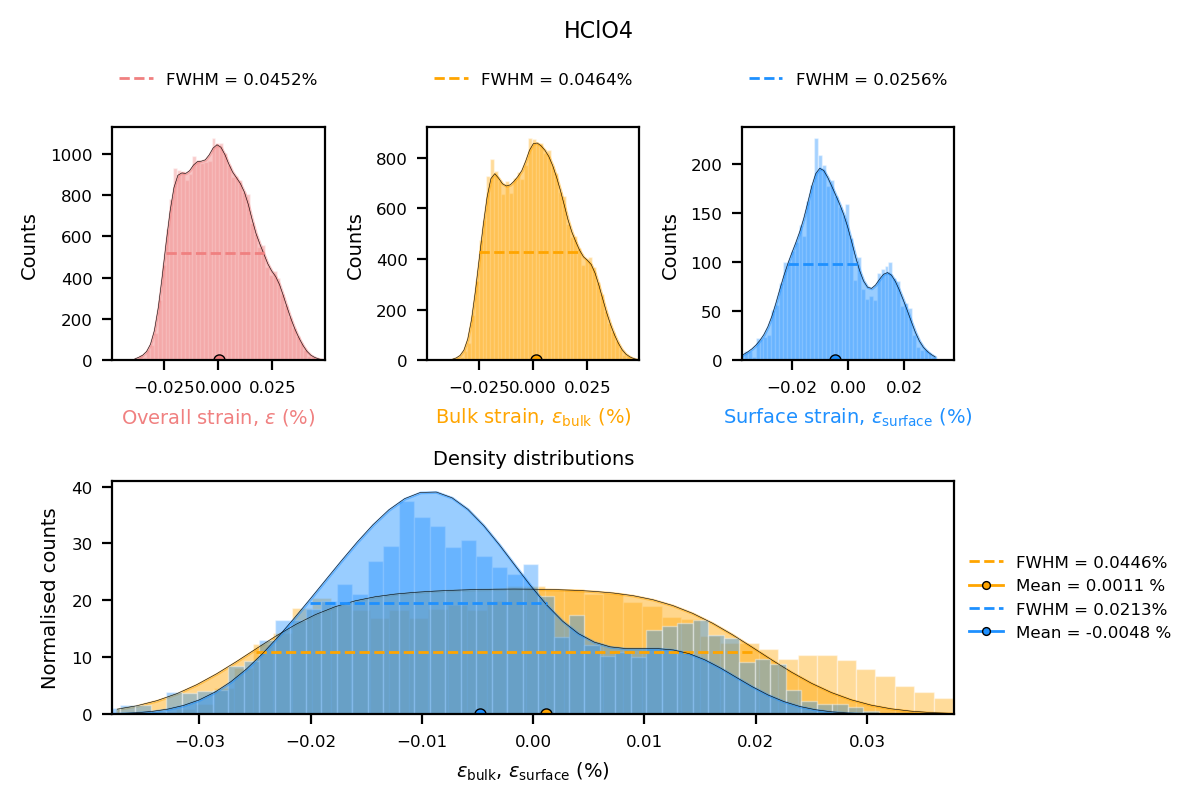

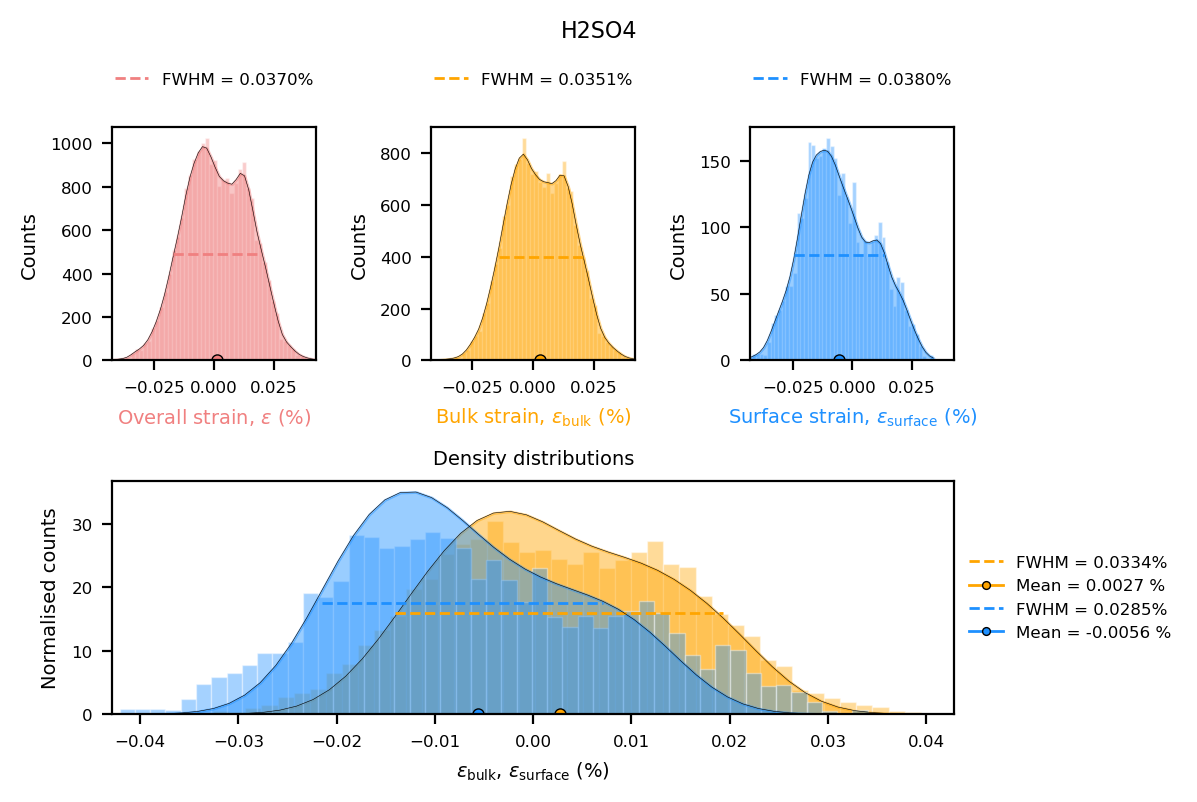

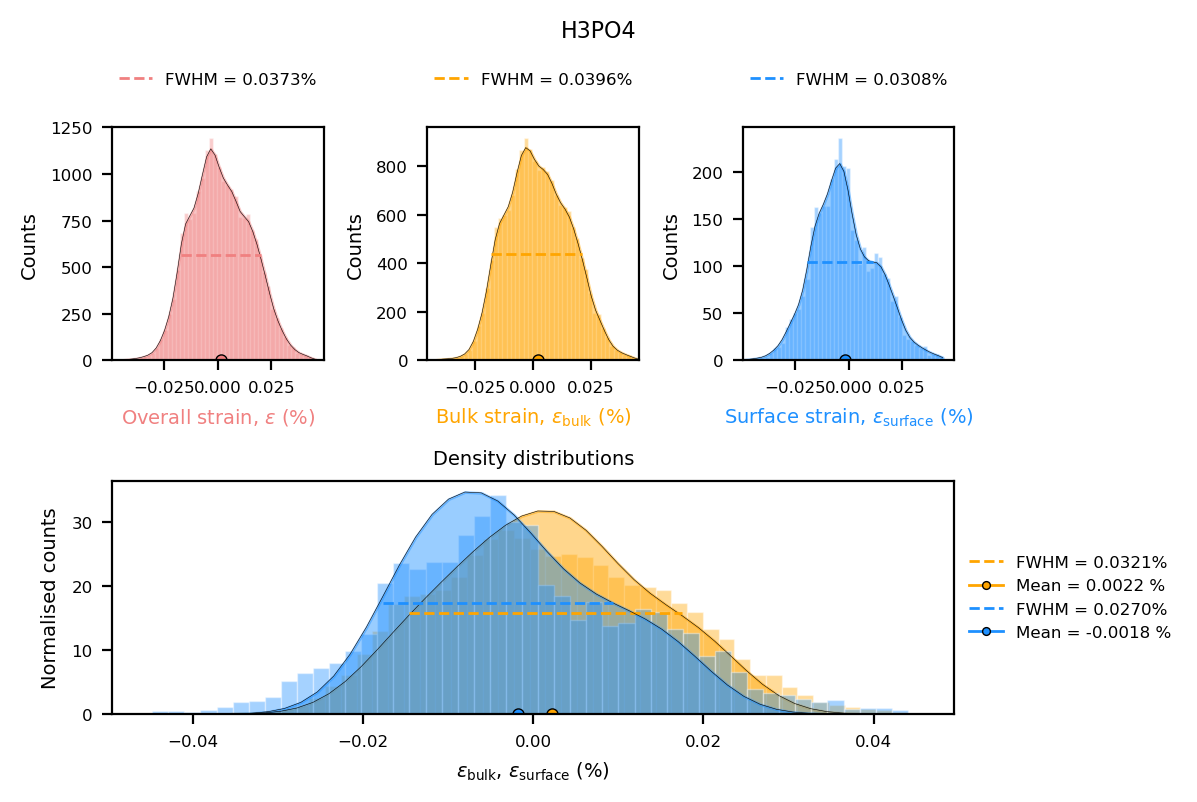

In [15]:
for condition, _, _ in table:
    strain_data = structural_properties[condition]["het_strain"] 
    support = structural_properties[condition]["support"]
    cdiutils.pipeline.PipelinePlotter.strain_statistics(
        strain_data, support, title=condition
    )
    

## 5. Next Steps

For further analysis, consider:
- Exporting key results as publication-ready figures using `cdiutils.plot.save_fig()` or `plt.Figure.savefig()`
- Performing facet analysis to identify crystallographic facets
- Quantifying differences between experimental conditions
- Correlating strain with structural features

## Feedback and Support

If you encounter any issues or have suggestions:
- Email: [clement.atlan@esrf.fr](mailto:clement.atlan@esrf.fr?subject=cdiutils)
- GitHub: [Report an issue](https://github.com/clatlan/cdiutils/issues)

## Credits
This notebook was created by Clément Atlan, ESRF, 2025. It is part of the `cdiutils` package, which provides tools for BCDI data analysis and visualisation.
If you have used this notebook or the `cdiutils` package in your research, please consider citing the package https://github.com/clatlan/cdiutils/
You'll find the citation information in the `cdiutils` package documentation.

```bibtex
@software{Atlan_Cdiutils_A_python,
author = {Atlan, Clement},
doi = {10.5281/zenodo.7656853},
license = {MIT},
title = {{Cdiutils: A python package for Bragg Coherent Diffraction Imaging processing, analysis and visualisation workflows}},
url = {https://github.com/clatlan/cdiutils},
version = {0.2.0}
}
```

